In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold

C:\Users\Napon\AppData\Local\Temp\ipykernel_18052\2572126352.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_excel('Data_Fatlim_Expanded_E.xlsx')
print(df.shape)
#df = df.dropna()
print(list(df.columns))

pdf = df[[ 'mises_a', 'mises_m', 's11a', 's22a', 's33a', 't12a', 't13a', 't23a', 's11m', 's22m', 's33m', 't12m', 't13m', 't23m', 'fi11', 'fi22', 'fi33', 'fi12', 'fi13', 'fi23', 'Rm', 'Re', 'f-1', 'f0', 't-1', 't0']]
print(pdf.shape)



train_x = pdf.copy()
test_x = pdf.copy()
train_y = pd.DataFrame(train_x.pop('f-1'), columns = ['f-1']) 
test_y = pd.DataFrame(test_x.pop('f-1'), columns = ['f-1'])

Ma = pd.DataFrame(train_x.pop('mises_a'), columns = ['mises_a'])
Mm = pd.DataFrame(train_x.pop('mises_m'), columns = ['mises_m'])

Mat = pd.DataFrame(test_x.pop('mises_a'), columns = ['mises_a'])
Mmt = pd.DataFrame(test_x.pop('mises_m'), columns = ['mises_m'])


x_train_tensor = torch.tensor(np.array(train_x), dtype=torch.float32).requires_grad_(True).to('cuda')
y_train_tensor = torch.tensor(np.array(train_y), dtype=torch.float32).requires_grad_(True).to('cuda')
x_test_tensor = torch.tensor(np.array(test_x), dtype=torch.float32).requires_grad_(True).to('cuda')
Ma_tensor = torch.tensor(np.array(Ma), dtype=torch.float32).requires_grad_(True).to('cuda')
Mm_tensor = torch.tensor(np.array(Mm), dtype=torch.float32).requires_grad_(True).to('cuda')

print(train_x.shape, train_y.shape, Ma.shape)
print(Ma_tensor.shape, Mm_tensor.shape)

(1732, 62)
['Trans', 'index', 'set', 's11a', 's22a', 's33a', 's11m', 's22m', 's33m', 't12a', 't13a', 't23a', 't12m', 't13m', 't23m', 'fi11', 'fi22', 'fi33', 'fi12', 'fi13', 'fi23', 'propo', 'Testing', 'mat', 'matgr', 'Rm', 'Re', 'f-1', 'f0', 'b-1', 'b0', 'rb-1', 't-1', 't0', 'Nx', 'gramWalker', 'gramWalker_ann', 'gramWalkerE_ann', 'mises_a', 'mises_m', 'mises', 'misesE', 'E_Mpa', 'poi', 'walkerE', 'walkerE_ann', 'walker_ann', 'walker', 'SWT', 'smith', 'soderberg', 'ASME', 'Bagci', 'Gerber', 'fNP_Bishop', 'fNP_Itoh', 'psi_max', 'S_eq', 'f-1_max', 'S_eq_mises_max', 'WS_a', 'WS_m']
(1732, 26)
(1732, 23) (1732, 1) (1732, 1)
torch.Size([1732, 1]) torch.Size([1732, 1])


In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()

        self.normalization = nn.BatchNorm1d(input_size)

        self.fc_layers = nn.Sequential(

            nn.Linear(input_size, 300),
            nn.ReLU(),

            nn.Linear(300, 300),
            nn.ReLU(),

            nn.Linear(300, 300),
            nn.ReLU(),

            nn.Linear(300, 300),
            nn.ReLU(),

            nn.Linear(300, 300),
            nn.ReLU(),

            nn.Linear(300, 300),
            nn.ReLU(),

            nn.Linear(300, output_size)
        )
    
    def forward(self, x):

        out = self.normalization(x)
        out = self.fc_layers(out)

        return out

Epoch [5000/5000], Loss: 851.34  

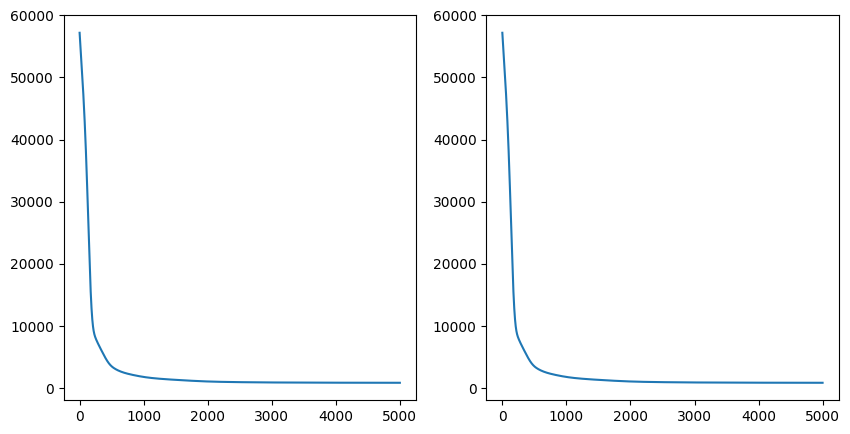

In [9]:
seed = 777
torch.manual_seed(seed)

lossesNN = []

model = NeuralNetwork(23, 1).to('cuda')
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

epochs = 5000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    s = model(x_train_tensor)

    a = ((Ma_tensor + Mm_tensor)**(1-s))*(Ma_tensor**s)

    loss1 = loss( a, y_train_tensor.to('cuda'))

    lossesNN.append(loss1.item())
    loss1.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'\rEpoch [{epoch + 1}/{epochs}], Loss: {(loss1.item()):.2f}', end=' ')


fig_1, axs = plt.subplots(1, 2, figsize=(10, 5))
#fig_1.suptitle('Normal plot')
axs[0].plot(lossesNN, label='Training Loss')

axs[1].plot(lossesNN, label='Training Loss')
#axs[1].set_xlim((epochs*0.5), epochs)
#axs[1].set_ylim( lossesNN[int(epochs-1)], lossesNN[int(epochs*0.5)])

In [10]:
with torch.no_grad():
    output = model(x_train_tensor)
    output = output.to('cpu')  
    
Y_pred = output.detach().numpy()

prediction = pd.DataFrame(Y_pred, columns = ['Y_pred'])
prediction['f-1'] = train_y.reset_index(drop=True)
prediction['Maise_a'] = Ma.reset_index(drop=True)
prediction['Maise_m'] = Mm.reset_index(drop=True)
prediction['walker'] = ((prediction['Maise_a'] + prediction['Maise_m'])**(1-prediction['Y_pred']))*(prediction['Maise_a']**prediction['Y_pred'])

print(prediction)
print(prediction.describe())

        Y_pred         f-1     Maise_a     Maise_m      walker
0     0.536446  488.232163  576.058665    0.000000  576.058665
1     0.673743  488.232163  635.823577    0.000000  635.823577
2     0.753841  488.232163  559.389989    0.000000  559.389989
3     1.180665  488.232163  681.144079    0.000000  681.144079
4     0.695887  342.091304  282.548306  245.200000  341.671569
...        ...         ...         ...         ...         ...
1727  0.829378  207.259727  189.572961  189.572961  213.372702
1728  0.621749  705.037285  542.121688  542.121688  704.630783
1729  1.120601  419.585012  457.267647  457.267647  420.596914
1730  0.803428  465.776916  405.066796  405.066796  464.195351
1731  0.790849  477.143361  412.247547  412.247547  476.561405

[1732 rows x 5 columns]
            Y_pred          f-1      Maise_a      Maise_m       walker
count  1732.000000  1732.000000  1732.000000  1732.000000  1732.000000
mean      0.808872   385.089922   350.549085   198.417363   389.126020
std   

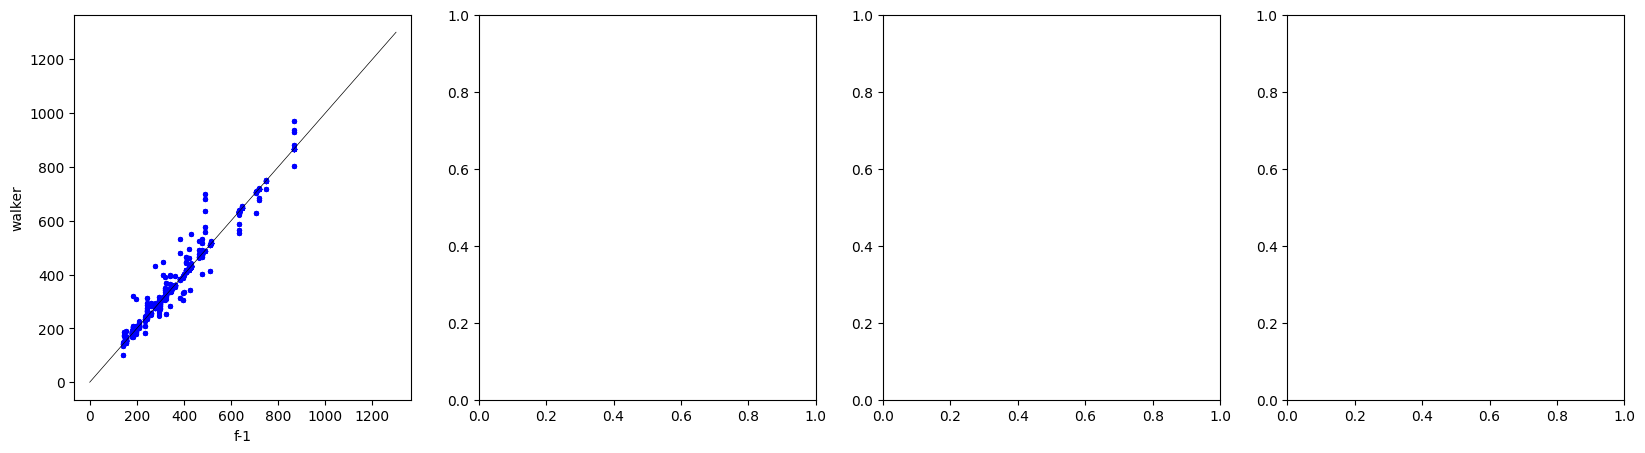

In [11]:
fig_1, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].scatter(prediction['f-1'], prediction['walker'], s=30 , marker='.', color='blue',label = "Mises")
axs[0].set(xlabel='f-1', ylabel='walker')
#axs[0].set_title("Mises_walker")
#axs[0].set_xlim([0, 1300])
#axs[0].set_ylim([0, 1300])
axs[0].plot([1300,0],[1300,0],'-',color='black', linewidth=0.5)

In [12]:
#prediction.to_csv('grammaW_1.csv', index=False)